In [1]:
from pyincore import InsecureIncoreClient, DataService, InventoryDataset
from pyincore import HazardService, FragilityService
from pyincore import PlotUtil, AnalysisUtil
import json
import time
import geopandas as gpd
from matplotlib import cm
import pandas as pd
import numpy as np

In [2]:
client = InsecureIncoreClient("http://incore2-services.ncsa.illinois.edu:8888", "jonglee")

# Data Service Module 
A python module to communicate IN-CORE data service
- query/search dataset
- download dataset
- upload dataset

In [3]:
#Initialize data service
datasvc = DataService(client)

In [4]:
#Search dataset with title containing "essential"
datasvc.get_datasets(title="essential")

[{'id': '5a284f42c7d30d13bc0821ba',
  'deleted': False,
  'title': 'Shelby County Essential Facilities',
  'description': '',
  'date': '2017-12-06T14:12:50-0600',
  'creator': 'ergo',
  'contributors': [],
  'fileDescriptors': [{'id': '5a284f42c7d30d13bc0821bd',
    'deleted': False,
    'filename': 'shelby_county_ef.dbf',
    'mimeType': 'application/octet-stream',
    'size': 49029,
    'dataURL': 'file:/home/incore/data/5a/28/5a284f42c7d30d13bc0821bd/shelby_county_ef.dbf',
    'md5sum': 'a6a319c9e37ca66543202ee340b4d84d'},
   {'id': '5a284f42c7d30d13bc0821c0',
    'deleted': False,
    'filename': 'shelby_county_ef.fix',
    'mimeType': 'application/octet-stream',
    'size': 1897,
    'dataURL': 'file:/home/incore/data/5a/28/5a284f42c7d30d13bc0821c0/shelby_county_ef.fix',
    'md5sum': 'ece074b7ed9710f89434c6db1bc1fc6c'},
   {'id': '5a284f43c7d30d13bc0821c3',
    'deleted': False,
    'filename': 'shelby_county_ef.prj',
    'mimeType': 'application/octet-stream',
    'size': 220,


In [5]:
#Sample dataset: 5ade51daec2309045650c157 (Shelby county essential facility)
#Download the dataset 
dataset_id = "5ade51daec2309045650c157"
ess_dataset = datasvc.get_dataset_metadata(dataset_id)
ess = datasvc.get_dataset_blob(ess_dataset['id'])

It already exsists; no unzip


In [6]:
buildings = InventoryDataset(ess)

In [7]:
gdf = gpd.GeoDataFrame.from_features(buildings.inventory_set)

In [8]:
gdf.shape

(723, 31)

In [9]:
# Using Geospatial Visualization Service 
layers = [{'id': dataset_id,'name': 'Essential Facilities', 'style':''}]
PlotUtil.get_wms_map(layers)

# Hazard Service Module
A Python module to communicate with hazard service 
- create a scenario earthquake or a scenario tornado
- query a hazard value at a location for a given scenario hazard 

In [10]:
hazardsvc = HazardService(client)

## Creating a scenario earthquake

In [11]:
#A configuration of a scenario earthquake
# attenuation function, epicener, magnitude, depth, etc.
eq_config = {
  "attenuations": {
    "AtkinsonBoore1995": "1.0"
  },
  "eqParameters": {
    "srcLatitude": "35.927",
    "srcLongitude": "-89.919",
    "magnitude": "7.9",
    "depth": "10.0"
  },
  "visualizationParameters": {
    "demandType": "PGA",
    "demandUnits": "g",
    "minX": "-90.3099",
    "minY": "34.9942",
    "maxX": "-89.6231",
    "maxY": "35.4129",
    "numPoints": "1025",
    "amplifyHazard": "true"
  }
}

In [12]:
#Create a scenario earthquake with the configuration
eq = hazardsvc.create_earthquake(json.dumps(eq_config))

In [13]:
eq

{'id': '5ae92e5fec23093994d26542',
 'attenuations': {'AtkinsonBoore1995': 1.0},
 'eqParameters': {'srcLatitude': 35.927,
  'srcLongitude': -89.919,
  'magnitude': 7.9,
  'coseismicRuptureDepth': 0.0,
  'dipAngle': 0.0,
  'azimuthAngle': 0.0,
  'rakeAngle': 0.0,
  'seismogenicDepth': 0.0,
  'depth': 10.0,
  'depth2p5KmPerSecShearWaveVelocity': 2.0,
  'shearWaveDepth1p0': 0.0,
  'faultTypeMap': {},
  'region': 'Global'},
 'visualizationParameters': {'demandType': 'PGA',
  'demandUnits': 'g',
  'minX': -90.3099,
  'minY': 34.9942,
  'maxX': -89.6231,
  'maxY': 35.4129,
  'numPoints': 1025,
  'amplifyHazard': True},
 'siteClassDataset': None,
 'privileges': {'userPrivileges': {'jonglee': 'ADMIN'}, 'groupPrivileges': {}},
 'defaultSiteClass': 'D',
 'siteAmplification': 'NEHRP',
 'rasterDatasetId': '5ae92e5fec230939943dde3e'}

In [14]:
#Visualize the building dataset and a scenario earthquake
layers = [
    {'id': eq['rasterDatasetId'],'name': 'earthquake', 'style':'earthquake-pga-g'},
    {'id': dataset_id,'name': 'Essential Facilities', 'style':''}
]
PlotUtil.get_wms_map(layers)

## Getting hazard value at 35.07899, -90.0178

In [15]:
hazardsvc.get_earthquake_hazard_value(eq['id'], "0.2 SA", "g", 35.07899, -90.0178)

0.5322993805448739

## Creating a scenario tornado

In [16]:
#Tornado configuration
# Mean width tornado
# EF rating, start and end positions
tornado_config = {
    "tornadoModel" : "MeanWidthTornado",
    "tornadoParameters" : { 
        "efRating" : "EF5",
        "startLatitude" : "35.092",
        "startLongitude" : "-90.091",
        "randomSeed" : "1234",
        "endLatitude" : [35.268],
        "endLongitude" : [-89.758],
        "windSpeedMethod" : "1" 
    }
}

In [17]:
tornado=hazardsvc.create_tornado_scenario(json.dumps(tornado_config))

In [18]:
tornado

{'id': '5ae92e6bec23093994d26543',
 'tornadoModel': 'MeanWidthTornado',
 'numSimulations': 1,
 'tornadoParameters': {'efRating': 'EF5',
  'maxWindSpeed': 250.0,
  'startLatitude': 35.092,
  'startLongitude': -90.091,
  'randomSeed': 1234,
  'windSpeedMethod': 1,
  'endLatitude': [35.268],
  'endLongitude': [-89.758]},
 'tornadoWidth': [815.9980909090909],
 'efBoxes': [{'efBoxWidths': [0.001002256638187928,
    0.0017328393158413994,
    0.0022321320000668874,
    0.0027387672237662794,
    0.003205018480359198,
    0.003671269736952117]}],
 'tornadoDatasetId': '5ae92e6bec230939943dde4a',
 'privileges': {'userPrivileges': {'jonglee': 'ADMIN'}, 'groupPrivileges': {}}}

In [19]:
#Visualize the a scenario tornado and buliding inventory
layers = [
    {'id': tornado['tornadoDatasetId'],'name': 'tornado', 'style':'tornado1'},
    {'id': dataset_id,'name': 'Essential Facilities', 'style':''}
]
PlotUtil.get_wms_map(layers)

## Getting a hazard value at 35.19487, -89.89712

In [20]:
hazardsvc.get_tornado_hazard_value(tornado['id'], "mph", 35.19487, -89.89712)

180.0189470412063

In [21]:
hazardsvc.get_tornado_hazard_value(tornado['id'], "mph", 35.24071, -89.81117)

133.0320513405737

# Fragility Service Module
A python module to communicate with Fragility Service
- Query fragility service
- Find (map) a fragility curve to a specific building
- mapping info (how to match a building to a fragility curve set

In [22]:
fragilitysvc = FragilityService(client)

In [23]:
aBuilding = buildings.inventory_set[0]

In [24]:
aBuilding

{'type': 'Feature',
 'id': '0',
 'geometry': {'type': 'Point',
  'coordinates': (-89.89352834234703, 35.20327006574139)},
 'properties': OrderedDict([('parid', '088012  00133C'),
              ('parid_card', '088012  00133C_1'),
              ('bldg_id', '088012  00133C_1_1'),
              ('struct_typ', 'S1'),
              ('str_prob', 1.0),
              ('year_built', 1997),
              ('no_stories', 1),
              ('a_stories', 1),
              ('b_stories', 0),
              ('bsmt_type', 'NONE'),
              ('sq_foot', 19592),
              ('gsq_foot', 19592),
              ('occ_type', 'COM7'),
              ('occ_detail', 'OFFICE MEDICAL'),
              ('major_occ', 'OFFICE MEDICAL'),
              ('broad_occ', 'Office Commercial'),
              ('appr_bldg', 1015500),
              ('repl_cst', 2328169),
              ('str_cst', 395789),
              ('nstra_cst', 942909),
              ('nstrd_cst', 989472),
              ('dgn_lvl', 'Moderate - Code'),
   

In [25]:
# Find a fragility curve with a given building
eq_fragility_mapping_id = "5aa9858d949f232724db46bd"
fragility_set = fragilitysvc.map_fragilities(eq_fragility_mapping_id, [aBuilding], "Non-Retrofit Fragility ID Code")
fragility_set

{'0': {'id': '5aa9858a949f232724db2d4c',
  'legacyId': 'STR_PFM_MTB_UL_475_S1_4',
  'description': 'Low-Rise Steel Moment Frame',
  'authors': ['Amr S. Elnashai', 'Seong-Hoon Jeong', 'Joshua S. Steelman'],
  'paperReference': None,
  'resultUnit': None,
  'resultType': 'Limit State',
  'demandType': 'PGA',
  'demandUnits': 'g',
  'hazardType': 'earthquake',
  'inventoryType': 'building',
  'fragilityCurves': [{'className': 'edu.illinois.ncsa.incore.service.fragility.models.PeriodStandardFragilityCurve',
    'description': 'Moderate',
    'median': -1.485,
    'beta': 0.441,
    'curveType': 'LogNormal',
    'periodParam2': 0.0,
    'periodParam1': 0.0,
    'periodParam0': 0.5,
    'periodEqnType': 1},
   {'className': 'edu.illinois.ncsa.incore.service.fragility.models.PeriodStandardFragilityCurve',
    'description': 'Extensive',
    'median': -0.962,
    'beta': 0.441,
    'curveType': 'LogNormal',
    'periodParam2': 0.0,
    'periodParam1': 0.0,
    'periodParam0': 0.5,
    'periodE

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

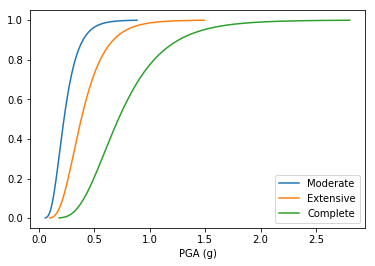

In [26]:
PlotUtil.get_fragility_plot(fragility_set[aBuilding['id']])

# Building Damage Analysis Module
A python module to compute building damage with inventory dataset and given hazard
- Hazard module and Fragility module are embed

In [27]:
# Acquire damage ratio dataset
damage_ratio_id = "5a284f2ec7d30d13bc08209a"
dmg_ratio = datasvc.get_dataset_blob(damage_ratio_id)

It already exsists; no unzip


In [28]:
from pyincore.analyses.buildingdamage import BuildingDamage

## Building damage with earthquake hazard

In [29]:
mapping_id = "5aa9858d949f232724db46bd"

# Initialize BulidingDamge class
## it will use Hazard and Fragility module
bldgDmg = BuildingDamage(client, "earthquake/"+eq['id'], dmg_ratio)

In [30]:
start = time.time()
output = bldgDmg.get_damage(buildings.inventory_set, mapping_id, 2, None, 1)
end = time.time()
print(str(end - start)+ " sec")

8.847334146499634 sec


In [33]:
start = time.time()
output = bldgDmg.get_damage(buildings.inventory_set, mapping_id, 2, None, 10)
end = time.time()
print(str(end - start)+ " sec")

2.0986642837524414 sec


## Buliding damage  with tornado hazard

In [34]:
tornado_mapping_id = "5ae0e51fff771b3240b6cce6"
bldgDmg_tornado = BuildingDamage(client, "tornado/"+tornado['id'], dmg_ratio)

In [36]:
start = time.time()
output = bldgDmg_tornado.get_damage(buildings.inventory_set, tornado_mapping_id, 2, None, 15)
end = time.time()
print(str(end - start)+ " sec")

2.079888105392456 sec


In [37]:
df = pd.read_csv(output)

In [38]:
#show top 5 highest mean damage
df.sort_values(by=['meandamage'],ascending=False).head()

,guid,immocc,lifesfty,collprev,insignific,moderate,heavy,complete,meandamage,mdamagedev,hazardtype,hazardval
540,0baa5126-68b7-4e32-9134-8f6c25346f2d,1.000000,1.000000,0.997627,1.378897e-12,3.023178e-10,0.002373,0.997627,0.899169,0.043703,wind,91.272543
445,a234237f-094d-4c45-b303-1d2669ceef29,1.000000,0.999984,0.870233,1.380415e-07,1.626985e-05,0.129751,0.870233,0.854575,0.128569,wind,74.462756
595,d1bbca6d-cda4-47e3-9eca-fcfe987e8560,0.999999,0.999931,0.800696,6.828807e-07,6.798139e-05,0.199236,0.800696,0.830216,0.151157,wind,71.973147
345,78b23681-62dd-43d6-a326-3cabc80bfeeb,0.999999,0.999873,0.762525,1.376159e-06,1.260488e-04,0.237348,0.762525,0.816833,0.160697,wind,70.861950
624,0e242301-f2e2-45a4-a3a1-ca258d67671f,1.000000,0.999729,0.760797,1.813461e-07,2.707495e-04,0.238932,0.760797,0.816172,0.161245,wind,72.639414


## Upload the output dataset to data repository by using Data Service Module

In [39]:
AnalysisUtil.create_result_dataset(datasvc, 
                                   ess_dataset['id'], 
                                   [output], 
                                   "tornado building dmg", 
                                   BuildingDamage.get_output_metadata())

'5ae92f2dec230939943dde68'

In [40]:
datasvc.get_dataset_metadata('5ae7973eec2309045c520f5f')

{'id': '5ae7973eec2309045c520f5f',
 'deleted': False,
 'title': 'tornado building dmg',
 'description': '',
 'date': '2018-04-30T17:22:54-0500',
 'creator': 'jonglee',
 'contributors': [],
 'fileDescriptors': [{'id': '5ae7973eec2309045c520f65',
   'deleted': False,
   'filename': 'dmg-results.csv',
   'mimeType': 'application/octet-stream',
   'size': 95791,
   'dataURL': 'file:/home/incore/data/5a/e7/5ae7973eec2309045c520f65/dmg-results.csv',
   'md5sum': 'df2965eb883693f5957c03e3fd6442af'}],
 'dataType': 'ergo:buildingDamageVer4',
 'storedUrl': '',
 'format': 'table',
 'sourceDataset': '5ade51daec2309045650c157',
 'spaces': ['jonglee'],
 'privileges': {'userPrivileges': {'jonglee': 'ADMIN'}, 'groupPrivileges': {}}}

In [41]:
#Visualize the a scenario tornado and buliding inventory
layers = [
    {'id': tornado['tornadoDatasetId'],'name': 'tornado', 'style':'tornado'},
    {'id': '5ae7973eec2309045c520f5f','name': 'dmg_output', 'style':'bldg-dmg'}
]
PlotUtil.get_wms_map(layers)